# Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore") # Ignore warnings while loading 
import iris
import numpy as np
from iris import Constraint
from matplotlib import pyplot as plt
import utils as fk
from joblib import Parallel, delayed
from glob import glob
#from tigramite import plotting as tp
#from tigramite.independence_tests import ParCorr  # , GPDC, CMIknn, CMIsymb
#from tigramite.pcmci import PCMCI
#from tigramite import data_processing as pp

## Data PATH
Please specify the directory path for the 'CMIP6_Historical_1900-2014.cvdp_data' folder

In [2]:
path_to_data='/your/path/to/data/CMIP6_Historical_1900-2014.cvdp_data/'

#### Parameters

In [3]:
plot_save =  True # Set to False for showing plots only

max_timelag=15 #Maximum Time lag for the PCMCI+ causal discovery algorithm (tau_max)

# significance level for the PC algorithm
pcalpha=0.05 # Can be a list of different values e.g. [0.01,0.05,0.1,0.2] or can set to None

#List of cube names for indices: PNA(DJF), PSA(ANN), PDV(MON), AMV(MON)
var_name_list=['pna_timeseries_djf','psa1_timeseries_ann',\
            'pdv_timeseries_mon','amv_timeseries_mon']#,'amv_timeseries_lowpass_mon']

## Permform regime-oriented PCMCI+ on Reanalysis data

The causal networks from this section would be used as reference for the model evaluation

#### Loading and preprocessing of the data

In [4]:
cvdpfile_obs_1=path_to_data+'ERSST_v5.cvdp_data.1900-2014.nc'
cvdpfile_obs_2=path_to_data+'ERA20C_ERA5.cvdp_data.1900-2014.nc'  
modelname=cvdpfile_obs_1.split('/')[-1].split('.')[0]+cvdpfile_obs_2.split('/')[-1].split('.')[0]

#Create empty dict to store the cubes
cube_dict={}     

############ Load data from the two files
for cube_name in var_name_list[:2]: # PNA and PSA1 are from ERA20C_ERA5 data
    constraint=Constraint(cube_func=(lambda c: c.var_name == cube_name))
    cube_dict[cube_name]=iris.load(cvdpfile_obs_2,constraint)[0]

for cube_name in var_name_list[2:]: # PDV and AMV are from ERSST_v5 data
    constraint=Constraint(cube_func=(lambda c: c.var_name == cube_name))
    cube_dict[cube_name]=iris.load(cvdpfile_obs_1,constraint)[0]

############ Yearly average monthly cubes
cube_dict['amv_timeseries_ann']= fk.aggregate_by_year(cube_dict['amv_timeseries_mon'])
cube_dict['pdv_timeseries_ann']= fk.aggregate_by_year(cube_dict['pdv_timeseries_mon'])


amv_yr, pna, pdv_yr, psa1= cube_dict['amv_timeseries_ann'],cube_dict['pna_timeseries_djf'],cube_dict['pdv_timeseries_ann'],\
cube_dict['psa1_timeseries_ann']

###### Create data array of shape (Time length x Number of variables)
data = np.zeros((len(pna.data), 4))    

## Store detrented, yearly indices
data[:, 0] = fk.detrend_kw(amv_yr.data)
data[:, 1] = fk.detrend_kw(pna.data)
data[:, 2] = fk.detrend_kw(pdv_yr.data)
data[:, 3] = fk.detrend_kw(psa1.data)

# List of variable names
var_names=['$AMV$','$PNA$','$PDV$','$PSA1$']

# T, N = Shape of DataArray 
T, N = data.shape
print(data.shape)

# Create a Time string with Start year, End year, and Timelag
# only for saving purposes
timeir=pdv_yr.coord('year') #iris Dimcoord
timeirpoinz=timeir.points
stryr=timeirpoinz[0] # Start year
timestr=str(stryr)+'_'+str(timeirpoinz[-1])+'_tau_'+str(max_timelag)
#print(stryr, timeirpoinz[-1])


###############################################################
############ Low-pass filter for regimes: Savitsky Golay filter
############ See functions file : funkchions.py
maskingarr_pdv=fk.savitzky_golay(pdv_yr.data, 11, 1) # 11-year low-pass
maskingarr_amv=fk.savitzky_golay(amv_yr.data, 13, 1) # 13-year low-pass

#######################################
############## Define regimes (masking)
amvplus= np.where(fk.detrend_kw(maskingarr_amv) < 0, 1, 0) # AMV+
amvminus=np.where(fk.detrend_kw(maskingarr_amv) > 0, 1, 0) # AMV-
pdvplus= np.where(fk.detrend_kw(maskingarr_pdv) < 0, 1, 0) # PDV+
pdvminus=np.where(fk.detrend_kw(maskingarr_pdv) > 0, 1, 0) # PDV+
no_mask=np.zeros(amv_yr.data.shape)
pdvplus_amvplus=np.where((pdvplus + amvplus == 0), 0, 1) # PDV+/AMV+
pdvplus_amvminus=np.where((pdvplus + amvminus == 0), 0, 1) # PDV+/AMV-
pdvminus_amvplus=np.where((pdvminus + amvplus == 0), 0, 1) # PDV-/AMV+
pdvminus_amvminus=np.where((pdvminus + amvminus == 0), 0, 1) # PDV-/AMV-
inphase=np.where((pdvplus_amvplus+pdvminus_amvminus < 2),0,1) # IN PHASE
outphase=np.where((pdvplus_amvplus+pdvminus_amvminus == 2),0,1) # OUT OF PHASE


## Store regimes (masks) in dictionary    
regime_masks_dict={'No_mask': no_mask, 'AMV+': amvplus, 'AMV-': amvminus, 'PDV+':pdvplus, 'PDV-':pdvminus, 'InPhase':inphase, 'outphase':outphase,\
                    'PDVpAMVp': pdvplus_amvplus, 'PDVpAMVm':pdvplus_amvminus , 'PDVmAMVp':pdvminus_amvplus, 'PDVmAMVm':pdvminus_amvminus }        



months since 1900-01-15 00:00:00
cubes coordinates: ['Time']
year added to coords
months since 1900-01-15 00:00:00
cubes coordinates: ['Time']
year added to coords
(115, 4)


#### PCMCI+ over the complete period and all the defined regimes

Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/No_mask_115_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/AMV+_56_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/AMV-_59_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/PDV+_59_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/PDV-_56_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/InPhase_50_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/outphase_65_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/PDVpAMVp_25_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/PDVpAMVm_34_yr/
Successfully created the directory Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/PDVmAMVp_31_yr/
Successfully crea

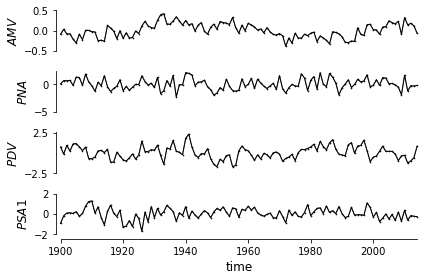

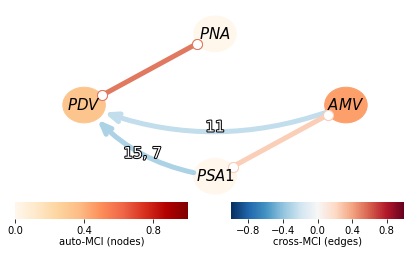

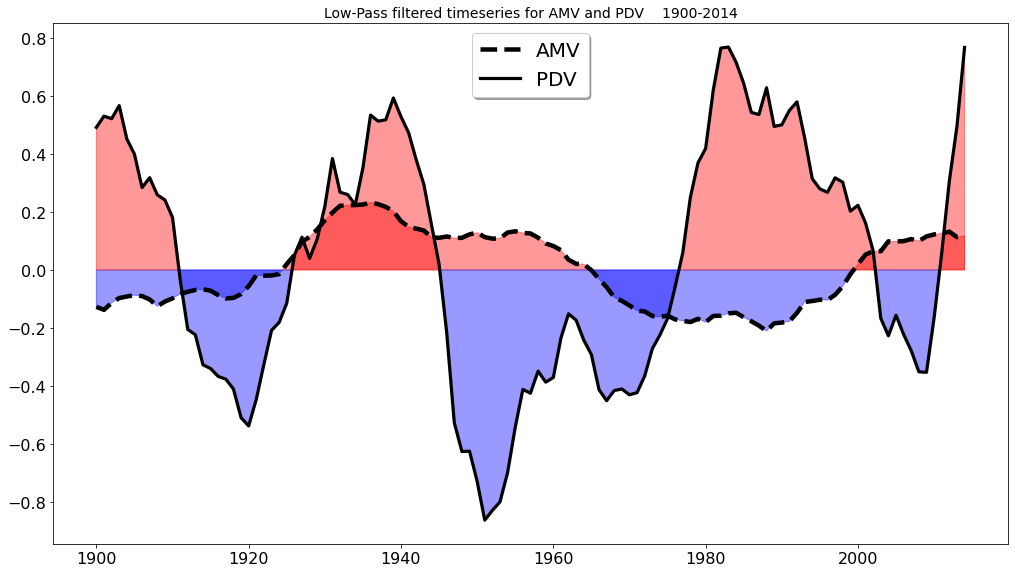

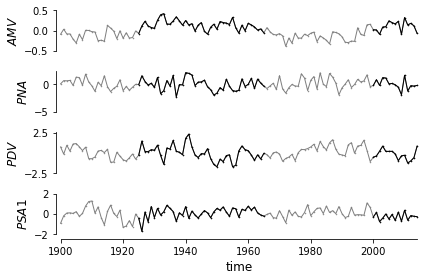

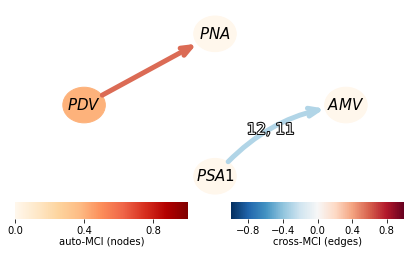

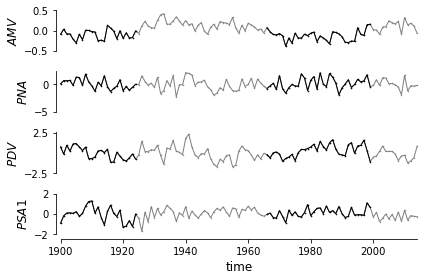

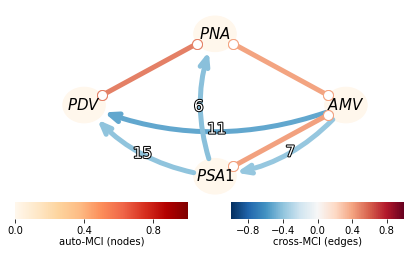

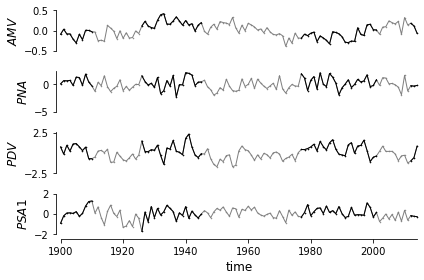

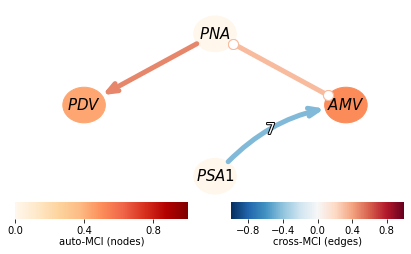

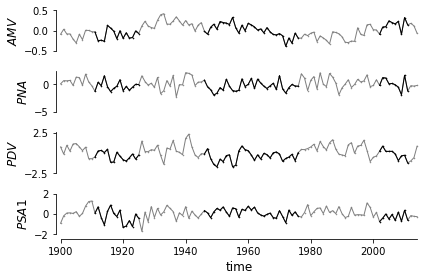

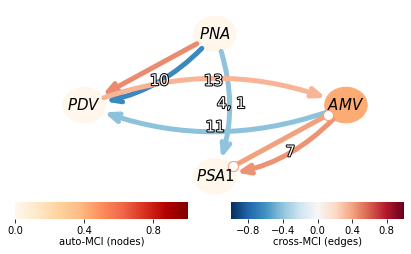

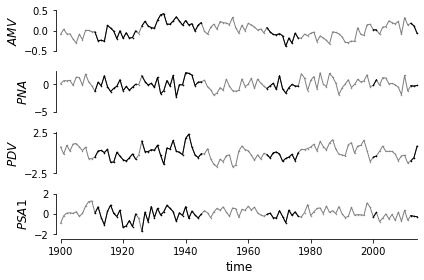

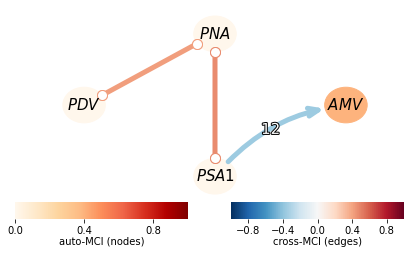

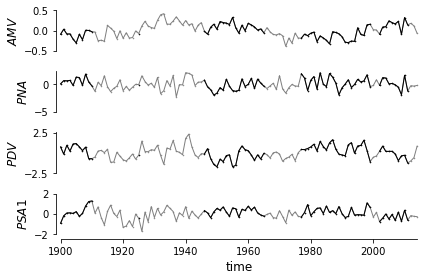

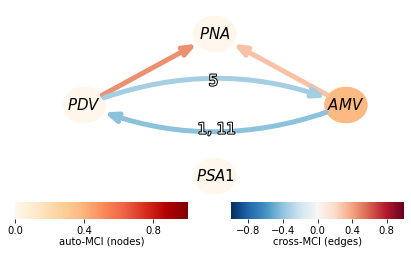

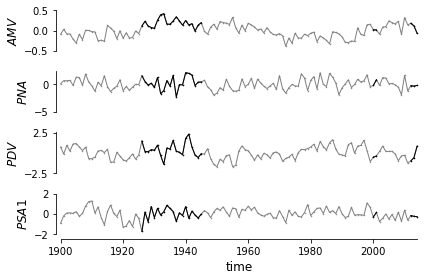

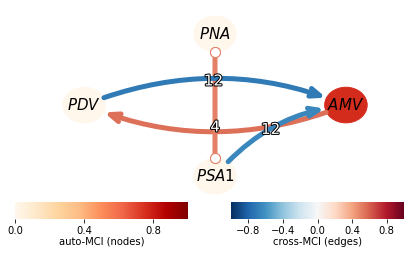

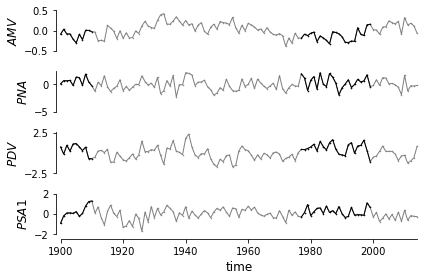

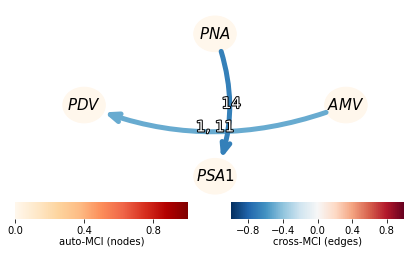

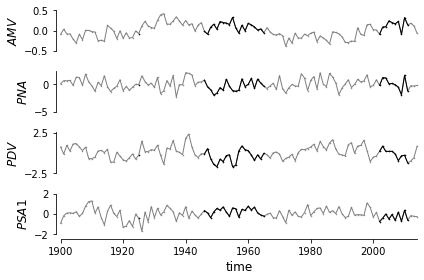

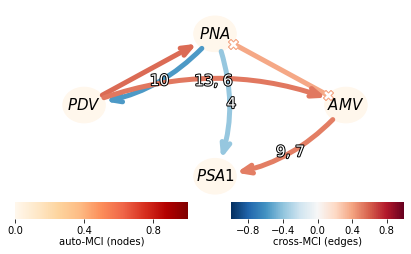

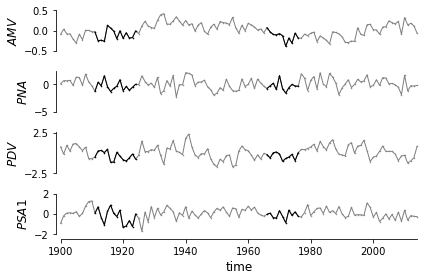

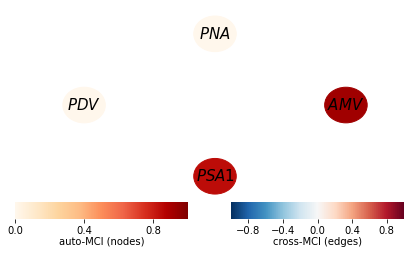

In [5]:
############### Loop the analysis over the different regimes
for regime in regime_masks_dict.keys():
    #print(regime)

    #Count the number of years for the regime
    yrs_per_regime=np.count_nonzero(regime_masks_dict[regime] == 0)

    #Create mask array same shape of data
    data_mask = np.zeros(data.shape)
    for i in range(len(data_mask[0])):
        data_mask[:, i] = regime_masks_dict[regime] # Apply the mask on the all four variables


    #### PCMCI dataframe
    dataframe = pp.DataFrame(data, datatime = timeirpoinz, var_names = var_names, mask = data_mask)

    #### Anaylsis can be done for different alpha levels for the PC algorithm
    ## For now we only use PC_alpha = 0.05

    ### Directory name to save results, UPDATE to your desired path
    out_dir='Results_DIR/'+modelname+'_'+timestr+'/'+regime+'_'+str(yrs_per_regime)+'_yr/'

    ### CREATE DIRECTORY
    ## One might need define the access rights as:
    # access_rights = 0o755

    try:
        os.makedirs(out_dir)#, access_rights)
    except OSError:
        print ("Creation of the directory %s failed" % out_dir)
    else:
        print ("Successfully created the directory %s" % out_dir)

    ###################################### TIGRAMITE : PCMCI+
    ###### Plot time series for indices

    if plot_save:
        plot_name = out_dir + modelname+'_'+timestr+'_cvdp_'+regime+'_timeseries.png' # save plot with this name
    else:
        plot_name= None
    tp.plot_timeseries(dataframe=dataframe, use_mask=True, grey_masked_samples='data',save_name=plot_name)


    # Next, we choose a conditional independence test, and set mask type to 'y'
    # this way parents from outside the masked period are allowed
    parcorr = ParCorr(significance='analytic', mask_type='y')

    # Then we initialise the PCMCI dataframe
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)

    #plot_name = None # show plot

    # correlations for PCMCI+ algorithm
    correlations = pcmci.run_bivci(tau_max=max_timelag, val_only=True)['val_matrix']

    ######################### Run PCMCI+ 
    results_masking = pcmci.run_pcmciplus(tau_min=0, tau_max=max_timelag, pc_alpha=pcalpha)

    ################# Plotting networks and saving  
    if plot_save:
        plot_name = out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_plt_causalgraph.png' # save plot with this name
    else:
        plot_name= None
    tp.plot_graph(    
        val_matrix=results_masking['val_matrix'],
        graph=results_masking['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI (edges)',
        node_colorbar_label='auto-MCI (nodes)',
        save_name=plot_name,
        node_label_size=15,
        link_label_fontsize=15,
        node_size=0.5,
        show_colorbar=True)

    ########################## Plot AMV & PDV low pass filter with colored phases
    if regime == 'No_mask': # We do it only once

        fig, ax = plt.subplots(figsize=(14,8))
        plt.title('Low-Pass filtered timeseries for AMV and PDV    1900-2014', fontsize=14)
        plt.plot(timeirpoinz, maskingarr_amv, 'k--',linewidth=4.5)
        plt.plot(timeirpoinz, maskingarr_pdv, 'k-',linewidth=3.2)
        plt.tight_layout()
        plt.fill_between(timeirpoinz, maskingarr_amv, 0.0,
                        where=(maskingarr_amv > 0),
                        alpha=0.4, color='red', interpolate=True)
        plt.fill_between(timeirpoinz, maskingarr_amv, 0.0,
                        where=(maskingarr_amv < 0),
                        alpha=0.4, color='blue', interpolate=True)

        plt.fill_between(timeirpoinz, maskingarr_pdv, 0.0,
                        where=(maskingarr_pdv > 0),
                        alpha=0.4, color='red', interpolate=True)
        plt.fill_between(timeirpoinz, maskingarr_pdv, 0.0,
                        where=(maskingarr_pdv < 0),
                        alpha=0.4, color='blue', interpolate=True)

        ax.tick_params(axis='both', labelsize=16)
        plt.legend(['AMV','PDV'], loc='upper center', shadow=True, prop={'size': 20})
        plt.savefig(out_dir+'lowpass_amv_pdv_timeseries_phases.png')

    ###################### Save data, mask, p_matrix, link_matrix, val_matrix
    #val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_data_dataframe.npy', 'wb')
    #np.save(val_out,data)
    #val_out.close()
    #val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_maska_array.npy', 'wb')
    #np.save(val_out,regime_masks_dict[regime] )
    #val_out.close() 
    
    val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_p_matrix.npy', 'wb')
    np.save(val_out,results_masking['p_matrix'] )
    val_out.close() 
    val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_link_matrix.npy', 'wb')
    np.save(val_out,results_masking['graph'] )
    val_out.close() 
    val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_val_matrix.npy', 'wb')
    np.save(val_out,results_masking['val_matrix'] )
    val_out.close()

## Regime-oriented PCMCI+ on CMIP6 Large Ensemble (LE) models

### Let's apply the same analysis above on CMIP6 LE models 
for simplicity, this sample version only uses two LE models

In [6]:
model_list=['ACCESS-ESM1-5_r','CESM2_r','CNRM-ESM2-1_r','CanESM5_r', 'EC-Earth3_r','GISS-E2-1-H_r','INM-CM5-0_r','IPSL-CM6A-LR_r','MIROC6_r','MPI-ESM1-2-LR_r','NorCPM1_r','UKESM1-0-LL_r']


### This part can be paralellized. Might not work here on Jupyter
(to do so, one can set 'n_jobs=-1' in the last line of the following cell)

###### Make sure to change the path to the data accroding to where it is stored (i.e. replace 'path_to_data' in the first line)

In [ ]:
def myfun(model):
    cvdp_file_list=glob(path_to_data+model+'*.nc') 
    for cvdpfile in cvdp_file_list[:]:
        modelname=cvdpfile.split('/')[-1].split('.')[0]
        ens=modelname.split('_')[0]
        ensm=modelname.split('_')[-1]
        #print(modelname) 
        #print(ensm)'ACCESS-ESM1-5_r',
        cube_dict={}

        for cube_name in var_name_list:
            constraint=Constraint(cube_func=(lambda c: c.var_name == cube_name))
            cube_dict[cube_name]=iris.load(cvdpfile,constraint)[0]
            
        
        cube_dict['amv_timeseries_ann']= fk.aggregate_by_year(cube_dict['amv_timeseries_mon'])
        cube_dict['pdv_timeseries_ann']= fk.aggregate_by_year(cube_dict['pdv_timeseries_mon'])

        amv_yr, pna, pdv_yr, psa1= cube_dict['amv_timeseries_ann'],cube_dict['pna_timeseries_djf'],cube_dict['pdv_timeseries_ann'],\
        cube_dict['psa1_timeseries_ann']

        timeir=pdv_yr.coord('year') #iris Dimcoord
        #print(timeir.points)
        #print(len(pna.data))

        data = np.zeros((len(pna.data), 4))    
        data[:, 0] = fk.detrend_kw(amv_yr.data)
        data[:, 1] = fk.detrend_kw(pna.data)
        data[:, 2] = fk.detrend_kw(pdv_yr.data)
        data[:, 3] = fk.detrend_kw(psa1.data)

        #var_names = ['AMV', 'PNA','PDV','PSA1'] 
        
        var_names=['$AMV$','$PNA$','$PDV$','$PSA1$']

        T, N = data.shape


        #print(data.shape)

        timeirpoinz=timeir.points
        stryr=timeirpoinz[0]
        #print(stryr, timeirpoinz[-1])
        timestr=str(stryr)+'_'+str(timeirpoinz[-1])+'_tau_'+str(max_timelag)

        datatime = np.arange(len(data))
        #####################################################################
        ############ Low-pass filter for regimes: Savitsky Golay filter


        maskingarr_pdv=fk.savitzky_golay(pdv_yr.data, 11, 1)
        maskingarr_amv=fk.savitzky_golay(amv_yr.data, 13, 1)



        ####################################################################


        amvplus= np.where(fk.detrend_kw(maskingarr_amv) < 0, 1, 0)
        amvminus=np.where(fk.detrend_kw(maskingarr_amv) > 0, 1, 0)
        pdvplus= np.where(fk.detrend_kw(maskingarr_pdv) < 0, 1, 0)
        pdvminus=np.where(fk.detrend_kw(maskingarr_pdv) > 0, 1, 0)
        no_mask=np.zeros(amv_yr.data.shape)
        pdvplus_amvplus=np.where((pdvplus + amvplus == 0), 0, 1)
        pdvplus_amvminus=np.where((pdvplus + amvminus == 0), 0, 1) 
        pdvminus_amvplus=np.where((pdvminus + amvplus == 0), 0, 1)
        pdvminus_amvminus=np.where((pdvminus + amvminus == 0), 0, 1)
        inphase=np.where((pdvplus_amvplus+pdvminus_amvminus < 2),0,1)
        outphase=np.where((pdvplus_amvplus+pdvminus_amvminus == 2),0,1)
        #outofphase=np.where((fk.detrend_kw(amv_yr.data)*fk.detrend_kw(amv_yr.data)) > 0, 1, 0)[2:63]
        #inphase=np.where(np.sign(fk.detrend_kw(amv_lp_yr.data[2:113])) != np.sign(fk.detrend_kw(pdv_lp_yr.data)) ,1, 0)
        #outofphase=np.where(np.sign(fk.detrend_kw(amv_lp_yr.data[2:113])) == np.sign(fk.detrend_kw(pdv_lp_yr.data)) ,1, 0)
        ## Regime-oriented Analysis - Masking    
        regime_masks_dict={'No_mask': no_mask, 'AMV+': amvplus, 'AMV-': amvminus, 'PDV+':pdvplus, 'PDV-':pdvminus, 'InPhase':inphase, 'outphase':outphase,\
                            'PDVpAMVp': pdvplus_amvplus, 'PDVpAMVm':pdvplus_amvminus , 'PDVmAMVp':pdvminus_amvplus, 'PDVmAMVm':pdvminus_amvminus }        

        for regime in regime_masks_dict.keys():
            print(regime)
            yrs_per_regime=np.count_nonzero(regime_masks_dict[regime] == 0)
            if yrs_per_regime < max_timelag:
                print('regime too short: ', yrs_per_regime)
            else:
                    
                data_mask = np.zeros(data.shape)
                for i in range(len(data_mask[0])):
                    data_mask[:, i] = regime_masks_dict[regime]

                dataframe = pp.DataFrame(data, datatime = timeirpoinz, var_names = var_names, mask = data_mask)


                out_dir='Results_DIR/'+ens+'/'+modelname+'_'+timestr+'/'+regime+'_'+str(yrs_per_regime)+'_yr/'

                try:
                    os.makedirs(out_dir)#, access_rights)
                except OSError:
                    print ("Creation of the directory %s failed" % out_dir)
                else:
                    print ("Successfully created the directory %s" % out_dir)

            

                # Next, we choose a conditional independence test, here we start with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` method with  ``dataframe``, ``cond_ind_test``, and (optionally) ``var_names``:
                parcorr = ParCorr(significance='analytic', mask_type='y')

                pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)

                #plot_name = None # show plot

                
                correlations = pcmci.run_bivci(tau_max=max_timelag, val_only=True)['val_matrix']

                results_masking = pcmci.run_pcmciplus(tau_min=0, tau_max=max_timelag, pc_alpha=pcalpha)

                q_matrix = pcmci.get_corrected_pvalues(p_matrix=results_masking['p_matrix'], tau_max=max_timelag, fdr_method='fdr_bh')
                #qgraph = pcmci.get_graph_from_pmatrix(q_matrix, tau_min=0, tau_max=max_timelag, alpha_level= pcalpha)
                
                
                tp.plot_graph(    
                    val_matrix=results_masking['val_matrix'],
                    graph=results_masking['graph'],
                    var_names=var_names,
                    link_colorbar_label='cross-MCI (edges)',
                    node_colorbar_label='auto-MCI (nodes)',
                    save_name=out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_plt_causalgraph.png',
                    node_label_size=15,
                    link_label_fontsize=15,
                    node_size=0.5,
                    show_colorbar=False)

                if regime == 'No_mask':
                    
                    ########################## Plot AMV & PDV low pass filter with colored phases
                    fig, ax = plt.subplots(figsize=(14,8))
                    plt.title('Low-Pass filtered timeseries for AMV and PDV    1900-2014', fontsize=14)
                    plt.plot(timeirpoinz, maskingarr_amv, 'k--',linewidth=4.5)
                    plt.plot(timeirpoinz, maskingarr_pdv, 'k-',linewidth=3.2)
                    plt.tight_layout()
                    plt.fill_between(timeirpoinz, maskingarr_amv, 0.0,
                                    where=(maskingarr_amv > 0),
                                    alpha=0.4, color='red', interpolate=True)
                    plt.fill_between(timeirpoinz, maskingarr_amv, 0.0,
                                    where=(maskingarr_amv < 0),
                                    alpha=0.4, color='blue', interpolate=True)

                    plt.fill_between(timeirpoinz, maskingarr_pdv, 0.0,
                                    where=(maskingarr_pdv > 0),
                                    alpha=0.4, color='red', interpolate=True)
                    plt.fill_between(timeirpoinz, maskingarr_pdv, 0.0,
                                    where=(maskingarr_pdv < 0),
                                    alpha=0.4, color='blue', interpolate=True)

                    ax.tick_params(axis='both', labelsize=16)
                    plt.legend(['AMV','PDV'], loc='upper center', shadow=True, prop={'size': 20})
                    plt.savefig(out_dir+'lowpass_amv_pdv_timeseries_phases.png')
                    ###################################################################

                #val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_data_dataframe.npy', 'wb')
                #np.save(val_out,data)
                #val_out.close()
                #val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_maska_array.npy', 'wb')
                #np.save(val_out,regime_masks_dict[regime] )
                #val_out.close() 
                val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_p_matrix.npy', 'wb')
                np.save(val_out,results_masking['p_matrix'] )
                val_out.close()     
                val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_link_matrix.npy', 'wb')
                np.save(val_out,results_masking['graph'] )
                val_out.close() 
                val_out = open(out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_val_matrix.npy', 'wb')
                np.save(val_out,results_masking['val_matrix'] )
                val_out.close()


# set n_jobs to -1 for parallelizing 
results = Parallel(n_jobs=1, backend="multiprocessing")(
             map(delayed(myfun), model_list[:]))
